# AdPMCMC on model $M_0$

In [142]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np

from scipy.stats import invgamma

import matplotlib.pyplot as plt
import seaborn
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Model $M_0$ : 
\begin{equation}
\log N_{t+1} = \log N_t + b_0 + \epsilon_t
\end{equation}

with $\epsilon_t \sim \mathcal{N}(0, \sigma_\epsilon^2)$. 

We put a Gaussian prior on the maximum per-individual growth rate parameter : $b_0 \sim \mathcal{N}(0, 1)$.
We use inverse Gamma priors for the variance noises :

$\sigma_\epsilon^2 \sim \mathcal{IG}(\alpha_\epsilon, \beta_\epsilon)$

$\sigma_w^2 \sim \mathcal{IG}(\alpha_w, \beta_w)$

with hyperpameters $\alpha_\epsilon=\alpha_w=T/2$ and $\beta_\epsilon=\beta_w=\frac{2(\alpha_\epsilon-1)}{10}$.

For synthetic data simulation, the authors set :

In [138]:
b_0 = 0.15
theta = 0.1
sigma_w = 0.39
sigma_eps = 0.47
n_0 = 1.17
T = 50

# prior hyperparameters
alpha_eps = alpha_w =  T/2
beta_eps = beta_w = 2*(alpha_eps -1)/10

In [139]:
def trajectory_simulation(T):
    log_N = np.zeros(T+1)
    log_N[0] = 1.17
    for t in range(T):
        log_N[t+1] = log_N[t] + b_0 + np.random.normal(0, sigma_eps**2)
    Y = np.exp(log_N) + np.random.normal(0, sigma_w**2, T+1)
    return(log_N, Y)

Problem : $g_t$ from the observation process is not defined in the paper.

Since, in the paper, $p(y_t | n_t, \sigma^2_w)$ is assumed to be the density of a Gaussian distribution with mean $n_t$ and variance $\sigma^2_w$, I assume $g_t$ is the identity function.

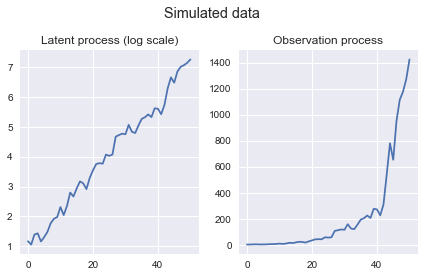

In [140]:
log_N, Y = trajectory_simulation(T)

f, (ax1, ax2) = plt.subplots(1, 2)
st = f.suptitle("Simulated data", fontsize="x-large")

ax1.plot(log_N)
ax1.set_title('Latent process (log scale)')
ax2.plot(Y)
ax2.set_title('Observation process')

plt.tight_layout()

st.set_y(0.95)
f.subplots_adjust(top=0.80)

TODO : 

- implement the three stages of AdPMCMC as described page 11


## Stage 1 : Annealed PMCMC



Random initialization of the parameters $(\theta, N_{1:T})$, followed by annealed AdPMCMC using a sequence of distribuitons :

\begin{equation}
p_n(\theta, N_{1:T} | y_{1:T}) = p(\theta, N_{1:T})^{1-\gamma_n}p(y_{1:T}|\theta, N_{1:T})^{\gamma_n}
\end{equation}

(in the model $M_0$, $\theta = (b_0, \sigma_\epsilon, \sigma_w)$

In [143]:
n_steps = 5000

# Random initialization
sigma_eps = invgamma.rvs(a=alpha_eps, scale=beta_eps)
sigma_w = invgamma.rvs(a=alpha_w, scale=beta_w)

In [144]:
sigma_eps

0.17217411594938578

## Stage 2 : Non adaptive PMCMC

## Stage 3 : Adaptive PMCMC